In [9]:
import os
from matplotlib import pyplot as plt   #Libreria que permite hacer plot
from PIL import Image #Procesamiento Digital de IMágenes PIL: Python Image Library
import numpy as np

In [ ]:
if not os.path.exists('lfwcrop_grey'):

    !wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip

    !unzip 'lfwcrop_grey.zip'

filenames = []
images = []

for filename in os.listdir('lfwcrop_grey/faces'):
    filenames.append(filename)
    image = np.array(Image.open(os.path.join('lfwcrop_grey/faces', filename)))
    images.append(image)

images = np.array(images)

print('Total Number of Faces: {}'.format(len(images)))
print(images.shape)
n = 64*64 #dimensión de mis datos (original) n = 4096 features
X = images.reshape(13233, n) # m = 13233 ejemplos de entrenamiento
print(X.shape)

**2. VISUALIZACIÓN DE LAS IMÁGENES**

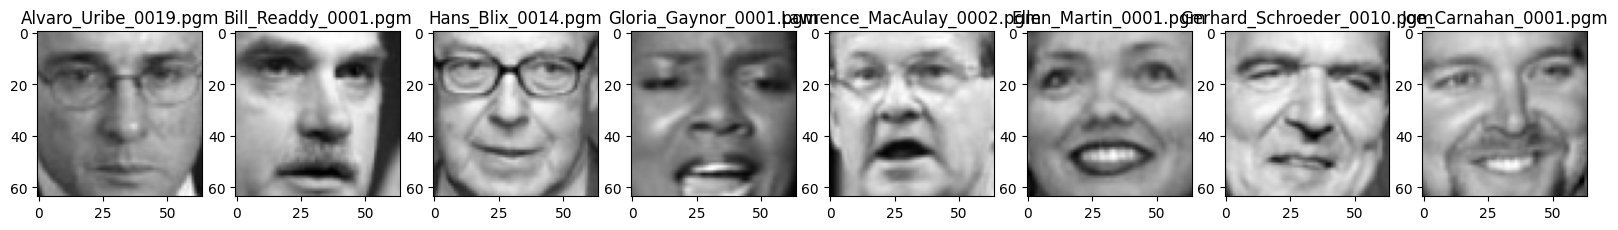

In [6]:
plt.figure(figsize=(20, 10))  #size de la imagen

num_images = 8 #Numero de imagenes
for i in range(num_images):

    plt.subplot(1, num_images, i+1)
    index = np.random.choice(range(len(images)))
    image = images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')  #que imprima en grises

    plt.title(filename)  #Imprima el nombre

**3. COMPRESION DE IMAGENES**

In [7]:
# SVD para PCA
print("Computando SVD...")
X_mean = np.mean(X, axis=0)  # Calcular la media de cada columna
X_centered = X - X_mean  # Centrar los datos
# Aplicar SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)  # SVD
# Determinar el número de componentes necesarios para retener al menos el 70% de la varianza
VR = 0.80  # Proporción mínima de varianza explicada deseada
explained_variance = S**2  # Varianza explicada proporcional a los valores singulares al cuadrado
total_variance = np.sum(explained_variance)  # Varianza total

# Sumar varianza explicada acumulada y determinar el número de componentes
cumulative_variance_ratio = np.cumsum(explained_variance) / total_variance
k = np.argmax(cumulative_variance_ratio >= VR) + 1  # Número de componentes necesarios
print(f"Número de componentes seleccionados para retener al menos el {VR*100}% de la varianza: {k}")

# Reducción de dimensionalidad usando los primeros k componentes
U_reduce = Vt[:k, :]  # Tomar las primeras k filas de Vt
Z = np.dot(X_centered, U_reduce.T)  # Proyectar los datos en el espacio reducido

# Mostrar los resultados
print("Dimensión original:", X.shape)
print("Dimensión reducida:", Z.shape)

# Verificar proporción de varianza explicada por k componentes
variance_retained = np.sum(explained_variance[:k]) / total_variance
print(f"Proporción de varianza explicada por {k} componentes: {variance_retained:.2f}")


Computando SVD...
Número de componentes seleccionados para retener al menos el 80.0% de la varianza: 33
Dimensión original: (13233, 4096)
Dimensión reducida: (13233, 33)
Proporción de varianza explicada por 33 componentes: 0.80


## Paso 2: Reconstrucción de la Imagen

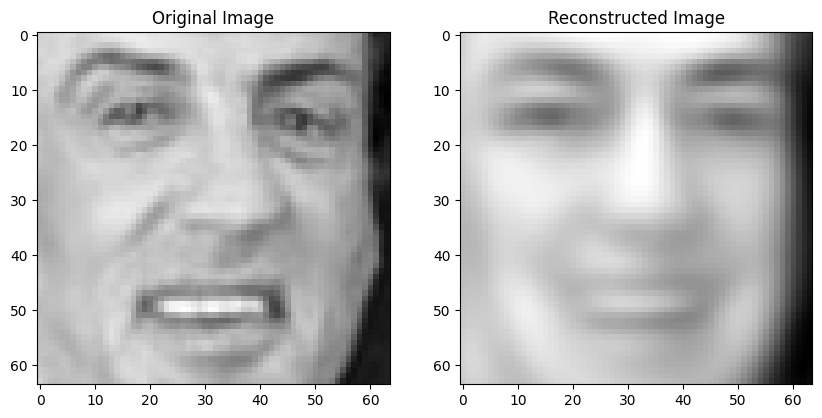

In [10]:
# Reconstrucción de los datos
import random


X_approx = np.dot(Z, U_reduce) + X_mean  # Transformación inversa al espacio original

# Seleccionar una imagen aleatoria para graficar
random.seed(877)
index = random.randint(0,13233)    #Escoge un aleatorio entre 0 a 13233 imaenes
reconstructed_image = X_approx[index] # Reconstruir la imagen
reconstructed_image = reconstructed_image.reshape(64, 64)
original_image = images[index]  # Imagen original

# Mostrar la imagen original y la reconstruida
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')

plt.show()

**Opción 2 (Simplificada): COMPRESIÓN DE LAS IMÁGNES UTLIZANDO DIRECTO EL COMANDO PCA**

Paso 1: Compresión de la Imagen (Reducción de la Dimensionalidad)


In [11]:
#Importar librerias
from sklearn import preprocessing
from sklearn.decomposition import PCA

explained_variance = 0.99 #varianza retenida =  varianza explicada = "información" retenida, la información que todavia se mantiene una vez comprimida la imagen
#Todos los componentes, retiene el 100%de la compresión, a medida que se reduce el tamaño se pierde información, se quiere retener el 99%de la información.

pca = PCA(explained_variance) #solo construyo el objeto pca, se usa la función, argumento dice que quiere que calcule para la información retenida el 0.99
pca.fit(X) #Implementa [U, S, V] = svd(Sigma); Ureduce = U(:,1:k) (ver diapositvas). Selecciona automáticamente k de modo que se retenga 99% de la varianza . Fit solo se hace en el training set.


#De cada 13233 de 64*64 = 4096 que son features, con el pca ahora disminuye a 577 features, disminuyendo la calidad de imagen.
z = pca.transform(X) # Implementa z = Ureduce'*x (ver diapositivas). En algebra lineal Ureduce o U son matrices de rotación

Ureduce = pca.components_.T #Ureduce nxk, reduciendo componentes principales

#puede demorar unos minutos
K = pca.n_components_

#Imprimir información
print("Los datos originales tienen dimensión", X.shape)
print("Los datos comprimidos tienen dimensión", z.shape)
print("El número de componentes principales K es", K, " que retienen el ", explained_variance*100, "% de la varianza")
print("El tam. de Ureduce (matriz de eigenvectors) es", Ureduce.shape)
print("PCA consigue reducir el tamaño en disco al ", K/n*100, "% de su tam. original")

Los datos originales tienen dimensión (13233, 4096)
Los datos comprimidos tienen dimensión (13233, 577)
El número de componentes principales K es 577  que retienen el  99.0 % de la varianza
El tam. de Ureduce (matriz de eigenvectors) es (4096, 577)
PCA consigue reducir el tamaño en disco al  14.0869140625 % de su tam. original


Paso 2: Reconstrucción de la Imagen

Label Sylvester_Stallone_0002.pgm


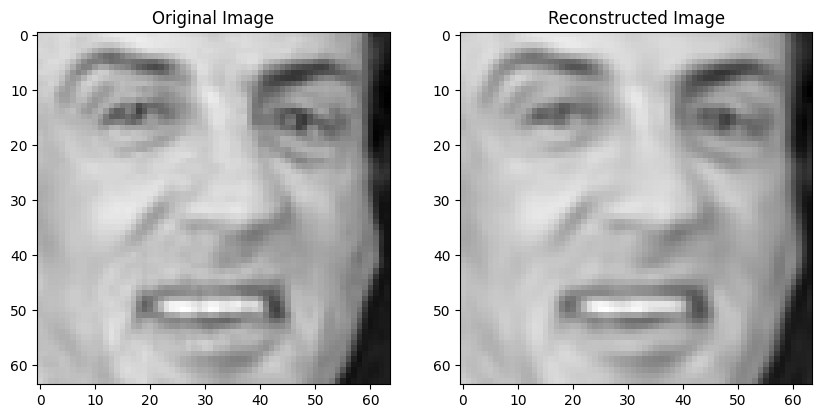

In [12]:
import random     #Se escoge 1 de todas las imagenes
random.seed(a=877)

#Implementa x_approx = Ureduce*z
X_approx = pca.inverse_transform(z) #transformada KL, Zscore por el PCA, no se usa el Ureduce ¨z ya se coloca la función
# índice de la imagen a graficar
index = random.randint(0,13233)    #Escoge un aleatorio entre 0 a 13233 imaenes
reconstructed_image = X_approx[index]
reconstructed_image = reconstructed_image.reshape(64, 64)
print('Label {}'.format(filenames[index]))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)    #Imprime 2 imagenes la original posicion 1
plt.title('Original Image')
plt.imshow(images[index], 'gray')

plt.subplot(1, 2, 2) #Imprime 2 imagenes la reconstruida posicion 1
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, 'gray')

**4. ACTIVIDADES DE LABORATORIO**

4.1 Varianza retenida vs Numero de componentes (k)

Grafique la varianza retenida en función del número de componentes principales retenidos k. Para esto, modifique la variable `explained_variance` con los siguientes valores: 0.99, 0.85, 0.7.

Para cada valor, verifique el número de componentes principales retenidos k. Además, imprimir lo siguiente por  pantalla:


1.   La dimensión de los datos comprimidos
2.   El número de componentes principales con su respectiva varianza retenida

In [21]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

varianza = [0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90, 0.85, 0.80, 0.75 , 0.7, 0.65, 0.6, 0.55, 0.5,0.45 , 0.4, 0.3, 0.2, 0.1] #varianza retenida =  varianza explicada = "información" retenida, la información que todavia se mantiene una vez comprimida la imagen
num_compo_k=[]

for x in varianza:
  pca = PCA(x) #solo construyo el objeto pca, se usa la función, argumento dice que quiere que calcule para la información retenida el 0.99
  pca.fit(X) #Implementa [U, S, V] = svd(Sigma); Ureduce = U(:,1:k) (ver diapositvas). Selecciona automáticamente k de modo que se retenga 99% de la varianza . Fit solo se hace en el training set.
  #De cada 13233 de 64*64 = 4096 que son features, con el pca ahora disminuye a 577 features, disminuyendo la calidad de imagen.
  z = pca.transform(X) # Implementa z = Ureduce'*x (ver diapositivas). En algebra lineal Ureduce o U son matrices de rotación

  Ureduce = pca.components_.T #Ureduce nxk, reduciendo componentes principales
#puede demorar unos minutos
  K = pca.n_components_

  num_compo_k.append(K)

print(num_compo_k)


[np.int64(577), np.int64(371), np.int64(276), np.int64(219), np.int64(180), np.int64(151), np.int64(130), np.int64(113), np.int64(99), np.int64(87), np.int64(52), np.int64(33), np.int64(22), np.int64(15), np.int64(10), np.int64(7), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(2), np.int64(1), np.int64(1)]


/var/folders/mt/ynd178zj0lsf9_dhk8rpqy200000gn/T/ipykernel_60261/3202137345.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


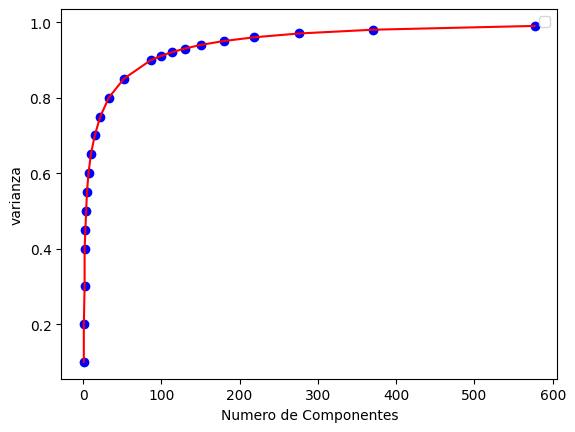

In [25]:

plt.scatter(num_compo_k,varianza, color="blue")
plt.plot(num_compo_k,varianza, color="red")
plt.ylabel("varianza")
plt.xlabel("Numero de Componentes")
plt.legend()
plt.show()

4.2 Compresión (número de componentes principales, k ) vs. calidad de imagen (k/n)

Grafique el porcentaje de compresión dado por k/n en función del número de componentes retenidos k. Para esto, modifique la variable explained_variance con los siguientes valores: 0.99, 0.85, 0.7. Para cada valor, verifique el número de componentes princiaples retenidos k.

/var/folders/mt/ynd178zj0lsf9_dhk8rpqy200000gn/T/ipykernel_60261/827919398.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


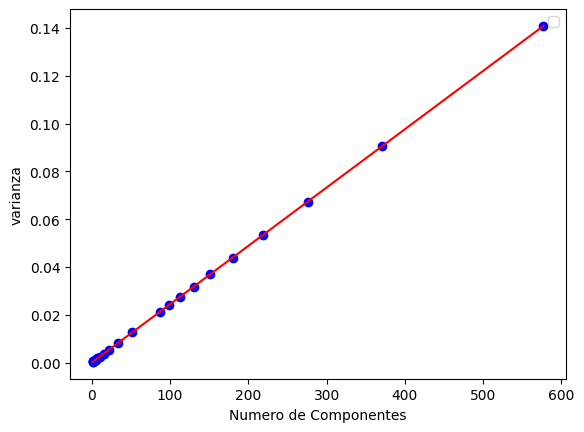

In [26]:

#varianza = [0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90, 0.85, 0.80, 0.75 , 0.7, 0.65, 0.6, 0.55, 0.5,0.45 , 0.4, 0.3, 0.2, 0.1] #varianza retenida =  varianza explicada = "información" retenida, la información que todavia se mantiene una vez comprimida la imagen
#num_compo_k=[]
calidad_imagen = []
for x, y in zip(varianza, num_compo_k):
   # print(f"Para retener el {x*100}% de la varianza se necesitan {y} componentes principales")
    calidad_imagen.append(y/n)

plt.scatter(num_compo_k,calidad_imagen, color="blue")
plt.plot(num_compo_k,calidad_imagen, color="red")
plt.ylabel("Varianza")
plt.xlabel("Numero de Componentes")
plt.legend()
plt.show()

4.3 Calidad vs Componente
Variando el valor de k (componentes principales), grafique un rostro en particular (e.g., index=777), para ver la pérdida de calidad a medida que el número de componentes k disminuye. Para esto asumir explained_variance con los siguientes valores: 0.99, 0.7, 0.5, 0.2. Tenga en cuenta que, para cada valor de explined_variance se tiene un valor de componente principal K. Por ejemplo, para explained_variance=0.99, se tiene K=577.

<Figure size 3000x4000 with 0 Axes>

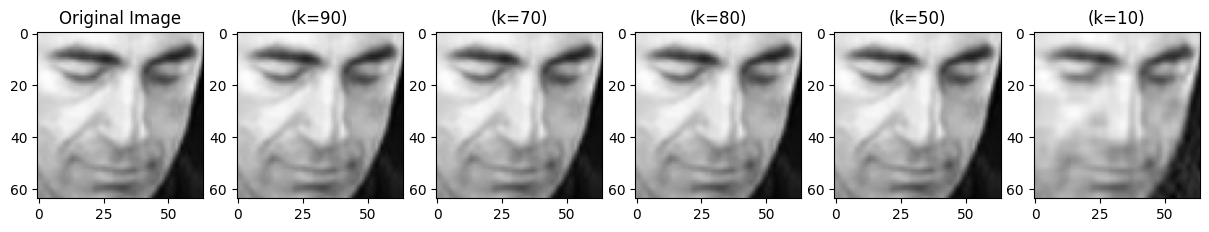

In [44]:
plt.figure(figsize=(30, 40))  #size de la imagen

num_images = 8 #Numero de imagenes
i = 777

image = images[index]
filename=filenames[index]
#plt.imshow(image, 'gray')  #que imprima en grises

# Compute SVD
U, S, VT = np.linalg.svd(image, full_matrices=False)

# Function to reconstruct image with top k singular values
def compress_image(k):
    Sigma_k = np.diag(S[:k])  # Keep top k singular values
    compressed_image = U[:, :k] @ Sigma_k @ VT[:k, :]
    return compressed_image

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")

for i, k in enumerate([90,70,80,50,10]):
    compressed_img = compress_image(k)
    axes[i + 1].imshow(compressed_img, cmap="gray")
    axes[i + 1].set_title(f"(k={k})")

plt.show()


CONCLUSIONES GENERALES

Colocar sus conclusiones y un comentario acerca de PCA o SVD

- A travez de los graficos se puede apreciar mejor el funcionamiento de los algoritmos tanto PCA como SVD, sobretodo para alguien que no es tan numerico como yo.

- Es interesante ver en practica como los mismos principios de una matriz se pueden verificar en una Imagen y mediante la reduccion de calidad entender por que son importantes los componentes principales.

- Se puede percibir en el grafico de Varianza vs el numero de componentes se puede apreciar que La curva de varianza indica que un número reducido de componentes principales puede retener un alto porcentaje de la información (por ejemplo, con 577 componentes se retiene mas del 85% de la varianza). Esto sugiere que los datos tienen una alta correlación, lo que permite una reducción dimensional efectiva, ademas en las imagenes se puede ver como aun se puede percibir la figura con un k de 10. 
- A medida que disminuye el umbral de varianza retenida, el número de componentes requeridos también baja significativamente. Esto significa que agregar más componentes después de cierto punto aporta poca información adicional.
- Como PCA utiliza Descomposición en Valores Singulares (SVD) para calcular los componentes principales, su ejecución en conjuntos de datos grandes puede ser costosa en términos computacionales. Elegir un umbral de varianza adecuado es clave para equilibrar rendimiento y precisión.
- Realizar la compresion y reconstruccion de una forma manual en lugar de usar la libraria, ayudo a entender mejor como se descompone la matriz original y se escoge el numero de K componentes y se muestre. 